# Simple experiment on synthetic data to validate the method

This is the first experiment ran on a very simplified synthetic dataset. The data contains 4 anomalies, all of which are spatially separated and their amplitudes are relatively even. The data is only contaminated with pseudo-random Gaussian noise. The idea behind this simple test is to very that the method works under idea conditions and to illustrate the several processing steps.

## Imports

Load the modules needed to run the experiment.

In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.colors
import skimage.exposure
import harmonica as hm
import verde as vd
# Our custom module for this paper
import micromag as mg

## Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 1000, 0, 1000],  # µm
    shape=(1000, 1000),  # µm
    extra_coords=sensor_sample_distance,
)

Now create the dipole model that will be used to generate the data.

In [3]:
dipole_coordinates = (
    [200,  500, 800,  800, 200],  # µm
    [200,  500, 800,  200, 800],  # µm
    [-1, -10, -7, -12, -3],  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=[-30 , 0, -50, 70, 50], 
    declination=[45, 0, 150, 270, 325],
    amplitude=[1e-15, 2e-13, 1.5e-14, 5e-14, 3e-14],
)
dipole_moments

array([[ 6.12372436e-16,  6.12372436e-16,  5.00000000e-16],
       [ 0.00000000e+00,  2.00000000e-13, -0.00000000e+00],
       [ 4.82090707e-15, -8.35005599e-15,  1.14906666e-14],
       [-1.71010072e-14, -3.14140405e-30, -4.69846310e-14],
       [-1.10606348e-14,  1.57962235e-14, -2.29813333e-14]])

Calculate the $b_z$ magnetic field of the dipoles and place them into an `xarray.DataArray` for easier handling.

In [4]:
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1000, x: 1000)
Coordinates:
  * x        (x) float64 0.0 1.001 2.002 3.003 4.004 ... 997.0 998.0 999.0 1e+03
  * y        (y) float64 0.0 1.001 2.002 3.003 4.004 ... 997.0 998.0 999.0 1e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 0.006798 0.006799 0.006799 ... -0.03725 -0.03688

Make a quick plot of the calculated field.

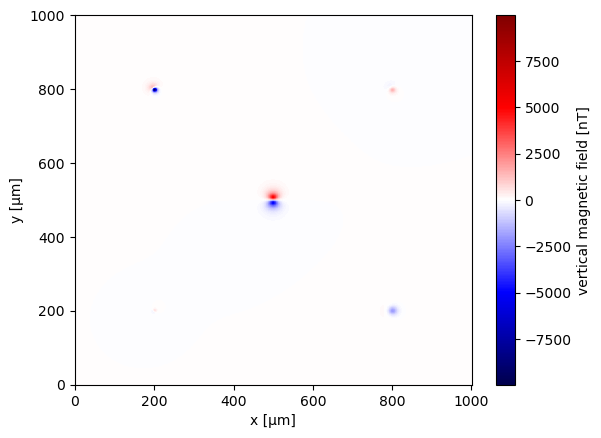

In [5]:
data.bz.plot.pcolormesh(cmap="seismic")

Add some random noise to make it more realistic.

In [6]:
noise_std_dev = 20  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

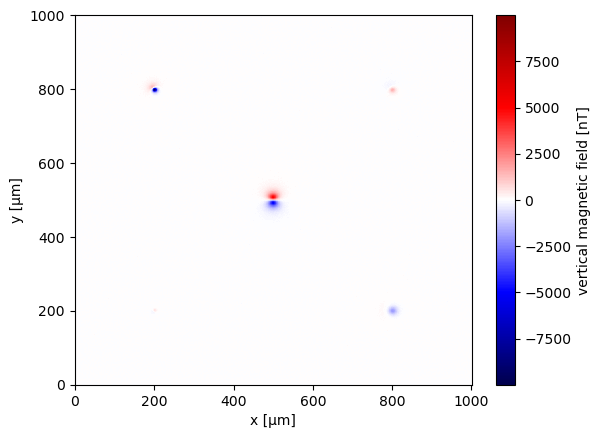

In [7]:
data.bz.plot.pcolormesh(cmap="seismic")

## Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
1. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
1. Contrast stretch the TGA to highlight weaker sources
1. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

### 1. Upward continue the data to suppress the noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [8]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1000, x: 1000)
Coordinates:
  * x        (x) float64 0.0 1.001 2.002 3.003 4.004 ... 997.0 998.0 999.0 1e+03
  * y        (y) float64 0.0 1.001 2.002 3.003 4.004 ... 997.0 998.0 999.0 1e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 0.2582 0.0998 -0.05782 ... 0.2953 0.3073 0.2727

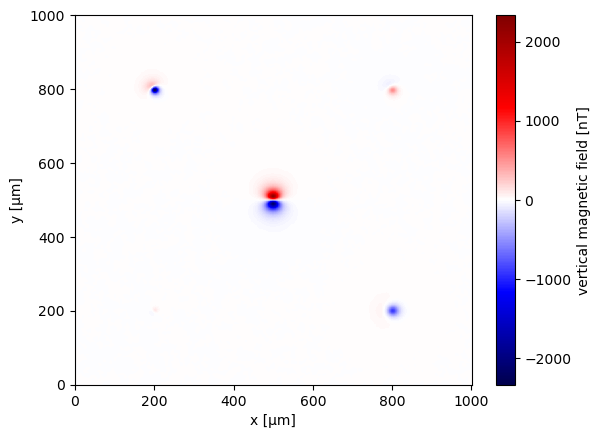

In [9]:
data_up.bz.plot.pcolormesh(cmap="seismic")

### 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [10]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1000, x: 1000)
Coordinates:
  * x        (x) float64 0.0 1.001 2.002 3.003 4.004 ... 997.0 998.0 999.0 1e+03
  * y        (y) float64 0.0 1.001 2.002 3.003 4.004 ... 997.0 998.0 999.0 1e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 0.2582 0.0998 -0.05782 ... 0.2953 0.3073 0.2727
    tga      (y, x) float64 0.2305 0.1786 0.1464 0.1169 ... 0.2566 0.2665 0.2554
    x_deriv  (y, x) float64 -0.1583 -0.1579 -0.1389 ... 0.02125 -0.0113 -0.03462
    y_deriv  (y, x) float64 0.05006 0.05069 0.0423 0.0126 ... 0.2006 0.1795 0.15
    z_deriv  (y, x) float64 -0.1599 -0.0663 0.01852 ... -0.1585 -0.1966 -0.2038

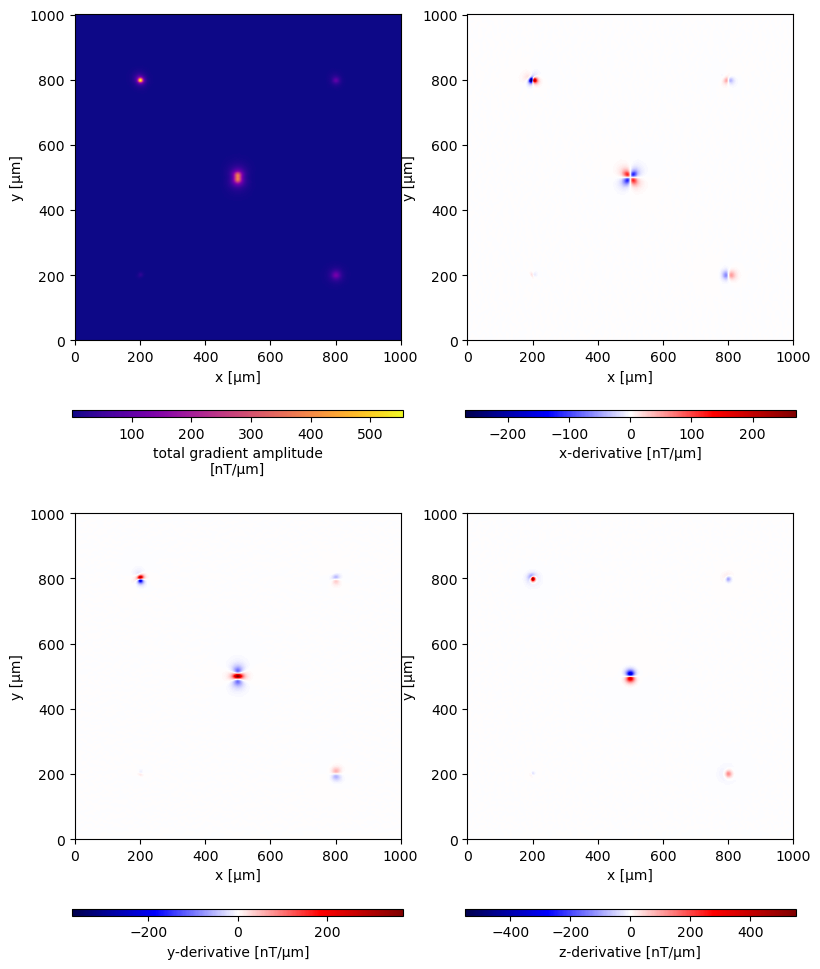

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [12]:
data_up = data_up.assign(tga_stretched=xr.DataArray(mg.enhance_image(data_up.tga.values, percentile=(1, 99)), coords=data_up.coords))

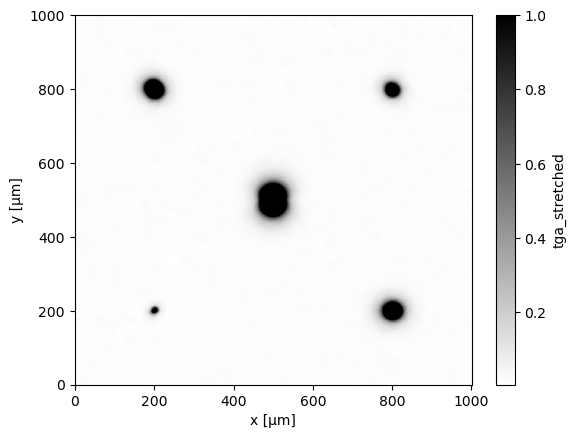

In [13]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

### 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [14]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[10, 100],
    size_increment=1.3,
    threshold=0.09,
    overlap=0.5,
)
windows

[[435.15278241152373,
  563.8462165874754,
  435.15278241152373,
  563.8462165874754],
 [153.23725842207364,
  245.16113997632482,
  753.8378590226743,
  845.7617405769255],
 [754.8388600236752, 846.7627415779265, 154.23825942307462, 246.1621409773258],
 [773.2236363345255, 828.3779652670762, 771.2216343325235, 826.3759632650742],
 [182.816424890351, 219.58597751205147, 182.816424890351, 219.58597751205147]]

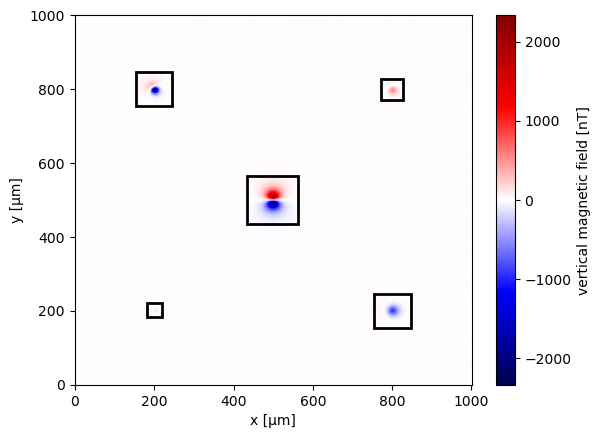

In [15]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run  the Euler deconvolution and moment inversion for each anomaly separately.

## Euler Deconvolution

Run the Euler Deconvolution on each window to compare the true and estimated source positions.

In [16]:
positions = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    print(position, base_level)
    positions.append(position)
positions = np.transpose(positions)

[500.00698552 500.00015542  -9.93992471] -0.03637230471047435
[199.99883976 799.99599777  -2.90561082] -0.24721052622183282
[799.98847596 199.97999939 -11.96179395] 0.07411816558517605
[800.02732292 800.04093998  -6.90585723] 0.6716205090043779
[199.90243884 200.00753138  -0.92429792] -0.05581432712648031


Find which estimated source corresponds to each actual source.

In [17]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
# z_difference

delta_z = z_difference
delta_x = positions[0] - np.array(dipole_coordinates[0])[closest]
delta_y = positions[1] - np.array(dipole_coordinates[1])[closest]

position_difference = np.sqrt(delta_x**2+delta_y**2+delta_z**2)
position_difference

array([0.06048026, 0.09448112, 0.04463777, 0.10623316, 0.12371624])

Plot the locations found and the error in z.

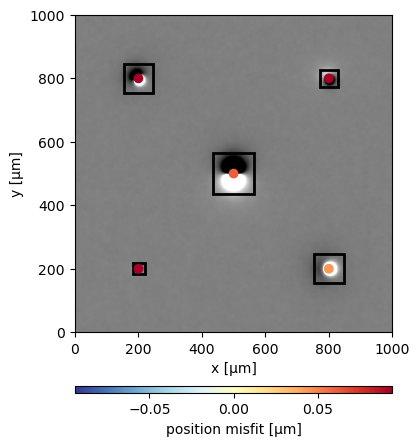

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-100, vmax=100, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=position_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale)
fig.colorbar(tmp, **cbar_kwargs, label="position misfit [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

## Dipole moment inversion

With the source positions found through Euler Deconvolution, we can now estimate the dipole moment through a linear inversion.

In [19]:
estimated_dipole_moments = []
estimated_stds = []
for window, position in zip(windows, positions.T):
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.bz, position,
    )
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    print("R²:", r2)
    print("SNR:", SNR)
    print()

R²: 0.9999891549644184
SNR: 49.672520677596026

R²: 0.9999365120035411
SNR: 42.40724834385539

R²: 0.9999723080297578
SNR: 45.61441675985557

R²: 0.9998719453022495
SNR: 42.08568913997587

R²: 0.9994997292526343
SNR: 33.013565759731364



From the R² values, we can tell that the fit to the data is very good. Now we can compare the true dipole moments against predictions.

In [20]:
for estimated, sigmas, true in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    print()

Inclination: 0.0 | 0.007335178441036638 ± 0.001
Declination: 0.0 | -0.01173498452780489 ± 0.001
Amplitude  : 2.000000e-13 | 1.987542e-13 ± 5.1e-18

Inclination: 49.99999999999999 | 50.01535718057094 ± 0.006
Declination: -35.00000000000002 | -35.06888723396357 ± 0.010
Amplitude  : 3.000000e-14 | 2.955917e-14 ± 2.7e-18

Inclination: 70.0 | 69.890540194968 ± 0.004
Declination: -90.00000000000001 | -90.47955776655198 ± 0.013
Amplitude  : 5.000000e-14 | 4.983316e-14 ± 2.8e-18

Inclination: -50.0 | -50.072038489099334 ± 0.012
Declination: 150.0 | 150.5560239297971 ± 0.021
Amplitude  : 1.500000e-14 | 1.483048e-14 ± 2.9e-18

Inclination: -29.999999999999996 | -29.47043180621813 ± 0.029
Declination: 45.0 | 45.567309171921494 ± 0.042
Amplitude  : 1.000000e-15 | 9.907583e-16 ± 6.0e-19



Plot both the true and estimated values in a stereonet.

## Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [21]:
import black
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

### Maps of data processing steps

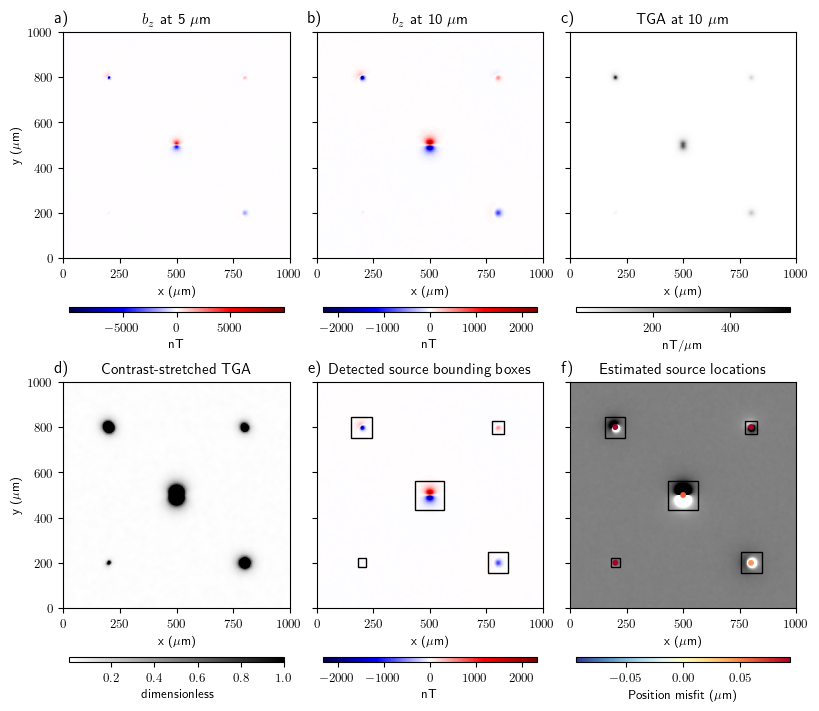

In [22]:
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(8, 7), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)

    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs)

    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs)

    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs)

    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)

    ax = axes[4]  
    ax.set_aspect("equal")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs)    
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   

    ax = axes[5]  
    ax.set_aspect("equal")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, add_colorbar=False, add_labels=False)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=position_difference, s=10, cmap="RdYlBu_r", vmin=-scale, vmax=scale)
    fig.colorbar(tmp, ax=ax, label="Position misfit ($\mu$m)", **cbar_kwargs)    

    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

    fig.savefig(fig_dir / "synthetic-data.png", dpi=200, facecolor='w', bbox_inches='tight')

plt.show()

### Dipole moment inversion results

/tmp/ipykernel_7026/1331174064.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)


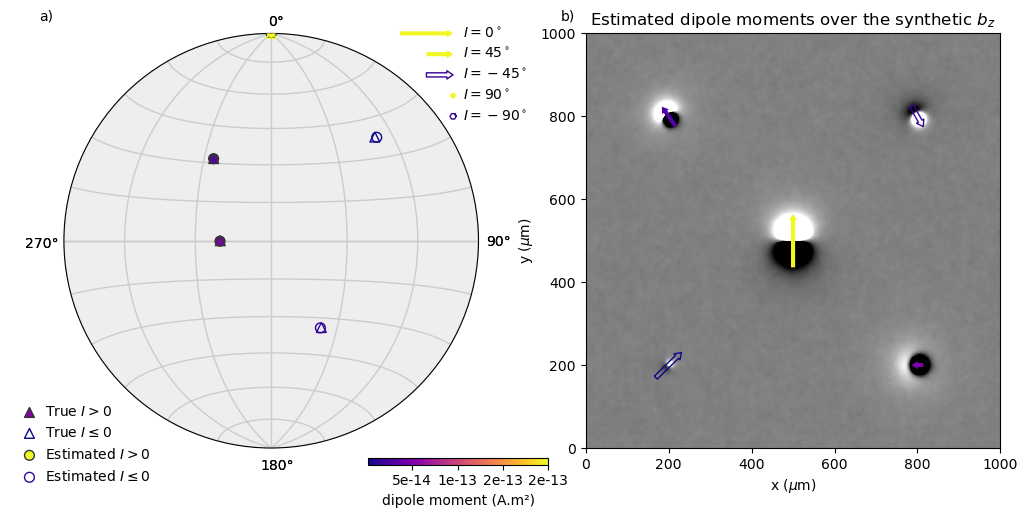

In [23]:
# with plt.rc_context(mpl_rc):
fig = plt.figure(figsize=(10, 7))
axes = []

ax = fig.add_subplot(1, 2, 1, projection='stereonet')
axes.append(ax)    
estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
true = mg.vector_to_angles(dipole_moments)[2]
vmin = np.min((estimated, true))
vmax = np.max((estimated, true))
cmap = "plasma"
# Use matplotlib.colors.LogNorm for a log scale
cmap_norm = matplotlib.colors.Normalize
kwargs = dict(
    ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
)    
tmp = mg.plot_stereonet(dipole_moments, marker="^", zorder=2000, label="True", **kwargs)
tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Estimated", **kwargs)
ax.legend(loc=(-0.13, -0.1), frameon=False, handletextpad=0.1)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0.35, 0.18, 0.18, 0.01]), 
    format="%.0g",
    label="dipole moment (A.m²)",
    orientation="horizontal",
)

ax = fig.add_subplot(1, 2, 2)
axes.append(ax)
ax.set_title(r"Estimated dipole moments over the synthetic $b_z$")
scale = 50
ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
tmp, posquiver, negquiver = mg.plot_dipole_moment(
    positions, estimated_dipole_moments, 
    ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
    scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
)
ax.set_xlabel(r"x ($\mu$m)")
ax.set_ylabel(r"y ($\mu$m)")
ax.set_aspect("equal")
# Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
ax.quiverkey(posquiver, -0.32, 1.00, 90, label=r"$I = 0^\circ$", labelpos="E")
ax.quiverkey(posquiver, -0.32, 0.95, 45, label=r"$I = 45^\circ$", labelpos="E")
ax.quiverkey(negquiver, -0.32, 0.90, 45, label=r"$I = -45^\circ$", labelpos="E")
ax.quiverkey(posquiver, -0.32, 0.85, 0., label=r"$I = 90^\circ$", labelpos="E")
ax.quiverkey(negquiver, -0.32, 0.80, 0., label=r"$I = -90^\circ$", labelpos="E")

for ax, letter in zip(axes, "a b".split()):
    ax.text(-0.06, 1.03, f"{letter})", transform=ax.transAxes)

plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)

    # fig.savefig(fig_dir / "simple-synthetic-dipole-moment.png", dpi=300, facecolor='w', bbox_inches='tight')

plt.show()